# Gradient Boosting
This notebook will outline the training and evaluation of our dataset using a shallow supervised learning technique known as gradient boosting. First, install the dependency `XGBoost`:

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Import the appropriate modules:

In [2]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm import tqdm
from collections import Counter

Now we will load the ground truths (see `data_prep_pipeline.ipynb` for how this is determined):

In [3]:
labels_df = pd.read_csv("ground_truths.csv")
labels_df

urban     rural  uninhabited
0      0.000000  0.677521     0.322479
1      0.000000  0.624206     0.375794
2      0.427418  0.363233     0.209349
3      0.204684  0.533722     0.261593
4      0.000000  0.690436     0.309564
...         ...       ...          ...
30439  0.000000  0.139570     0.860430
30440  0.000000  0.081930     0.918070
30441  0.000000  0.084599     0.915401
30442  0.000000  0.035771     0.964229
30443  0.000000  0.035978     0.964022

[30444 rows x 3 columns]

Next, we reduce each image tile $\mathbf{I}_i \in \mathbb{R}^{3 \times H \times W}$ to a compact numerical representation. For each $band \in \{\text{red, green, blue}\}$, define the following statistics over all pixels $x,y$ in $band$:
$$
\mu_{i,band} = \frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} \mathbf{I}_i [band][x][y],
$$$$
\sigma_{i,band} = \sqrt{\frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} (\mathbf{I}_i [band][x][y] - \mu_{i, band})^2},
$$$$
\min(\mathbf{I}_i[band]),
$$$$
\max(\mathbf{I}_i[band]),
$$

where $0 \leq i \leq N$ and $H$ is the height, $W$ is the width in pixels, and $N = 30444$ is the cleaned dataset size. The feature vector is

$$
\vec{x_i} = \begin{bmatrix} \mu_{i, \text{red}} & \sigma_{i, \text{red}} & \cdots & \mu_{i, \text{green}} & \sigma_{i, \text{green}} & \cdots & \mu_{i, \text{blue}} & \sigma_{i, \text{blue}} & \cdots \end{bmatrix} \in \mathbb{R}^{1 \times 12}.
$$

In [4]:
def extract_features(tif_path):
    with rasterio.open(tif_path) as src:
        img = src.read()
        B, H, W = img.shape
        features = []
        
        for b in range(B):
            band = img[b, :, :]
            mu = np.mean(band)
            sigma = np.std(band) 
            min_val = np.min(band)
            max_val = np.max(band)
            features.extend([mu, sigma, min_val, max_val])

    return np.array(features)

Stacking each $\vec{x_i}$, we get the feature matrix

$$
\mathbf{X} = \begin{bmatrix}
    \vec{x_0} \\
    \vec{x_1} \\
    \cdots \\
    \vec{x}_{N-1}
\end{bmatrix} \in \mathbb{R}^{N \times 12}.
$$

In [5]:
X = np.zeros((len(labels_df), 12)) 
for i in tqdm(range(len(labels_df))):
    X[i] = extract_features(f"HLS2-s30_rgb/tile{i}.tif")

100%|███████████████████████████████████████████████████████████████████████| 30444/30444 [03:20<00:00, 152.20it/s]


The target matrix $\mathbf{y} \in \mathbb{R}^{N \times 3}$ has each row $\vec{y_i} = \begin{bmatrix} p_{\text{urban}} & p_\text{rural} & p_\text{uninhabited}\end{bmatrix}$ representing a set of probabilities of each class being the dominant settlement type for each tile. Now, we can begin to formally define the model. For training, we derive discrete class labels via $t_i = \arg \max_c \vec{y_i}[c],$ where $t_i \in \{\text{urban, rural, uninhabited}\}$. 

In [6]:
y = labels_df.values.astype("float")
y_labels = np.argmax(y, axis=1)
y_labels

array([1, 1, 0, ..., 2, 2, 2], shape=(30444,))

The goal of gradient boosting is to approximate a function $f : \mathbb{R}^{12} \rightarrow \mathbb{R}^3$ using an additive model:

$$
F^{(T)}(\vec{x_i}) = \sum_{t=1}^T \eta f_t(\vec{x_i})
$$

where each $f_t$ is a regression tree, and $\eta \in (0, 1]$ is the learning rate controlling step size. At each boosting stage $t$, we update the model by fitting a tree to the negative gradient of the loss function with respect to the current predictions. For multiclass softmax classification, the loss per sample is the cross-entropy:

$$
\mathcal{L}_i = - \sum_{c=1}^3 \mathbb{1}[t_i = c] \ln{\bigg(\frac{   e^{ F^{(t-1)}_c(\vec{x_i}) }    }{  \sum_{c'}e^{  F^{(t-1)}_{c'}(\vec{x_i})  }  } \bigg)}.
$$

`XGBoost` uses a second-order Taylor expansion of the loss around the current predictions:

$$
\mathcal{L}^{(t)} \approx \sum_{i} \sum_{c=1}^3 \bigg[ \frac{\partial \mathcal{L}_i}{\partial F^{(t-1)}_c(\vec{x_i})} f_t(\vec{x_i}) + 0.5 \frac{\partial^2 \mathcal{L}_i}{\partial  F^{(t-1)}_c(\vec{x_i})^2} f_t(\vec{x_i})^2 \bigg] + \Omega(f_t),
$$

where $\Omega(f_t)$ is a regularization term penalizing tree complexity:

$$
\Omega(f_t) = \gamma T + \frac{1}{2} \lambda \sum_j w^2_j.
$$

To find the optimal hyperparameters, we perform **K-fold cross validation** wrapped in a randomized search. Formally, let $\Theta = \{(\eta, ..., \lambda, \alpha)\}$ denote the hyperparameter space. For each candidate $\theta \in \Theta$, we split the data into $K$ folds and compute the mean validation loss:

$$
\bar{\mathcal{L}}(\theta) = \frac{1}{K} \sum_{k=1}^K \mathcal{L}_{\text{test}}^{(k)}(\theta),
$$

where $\mathcal{L}_{\text{test}}^{(k)}(\theta)$ is the loss of the validation set at the $k$th fold. Then, the objective is to select

$$
\theta^* = \arg \min_{\theta \in \Theta} \bar{\mathcal{L}}(\theta).
$$

In [7]:
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist"
)

param_grid = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
    "reg_lambda": [1, 5],
    "reg_alpha": [0, 1],
}

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=7,
    verbose=1
)

grid.fit(X, y_labels)
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best cross-validated log loss:", -grid.best_score_)

Fitting 7 folds for each of 432 candidates, totalling 3024 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validated log loss: 0.1420444271180177


Once $\theta^*$ is found, we fit the model on all training data and evaluate on a hold-out set. The model outputs predicted class probabilities

$$
\hat{p_i} = \text{softmax}(F^{(T)}(\vec{x_i})).
$$

Due to extreme class imbalance, we also want to oversample minority classes to give more representation and balance out the dataset:

In [8]:
indices = np.arange(len(y))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_labels, indices, test_size=0.2, stratify=y_labels)

counter = Counter(y_train)
max_count = max(counter.values())
oversampled_X = []
oversampled_y = []

for cls in range(len(counter)):
    cls_indices = np.where(y_train == cls)[0]
    n_repeat = max_count // len(cls_indices)
    remainder = max_count % len(cls_indices)
    
    repeated_indices = np.tile(cls_indices, n_repeat)
    remainder_indices = np.random.choice(cls_indices, remainder, replace=False)
    final_indices = np.concatenate([repeated_indices, remainder_indices])
    
    oversampled_X.append(X_train[final_indices])
    oversampled_y.append(y_train[final_indices])

X_balanced = np.vstack(oversampled_X)
y_balanced = np.concatenate(oversampled_y)
perm = np.random.permutation(len(y_balanced))
X_train = X_balanced[perm]
y_train = y_balanced[perm]

Now that our model has been 7-fold cross-validated on a grid search of 432 candidates, we can see how well it performs by evaluating it on the following metrics:
- **Cross Entropy** (the *lower* the better)
- Accuracy (the higher the better)
- Macro Precision (the higher the better)
- Macro Recall (the higher the better)
- Macro F1 Score (the higher the better)

We specifically want to focus on the probabilistic **cross entropy** metric as our data has inherently soft labels rather than than discrete labels. 

In [9]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_probs = best_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cross_entropy = log_loss(y_test, y_pred_probs)

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

Cross Entropy: 0.2932
Accuracy: 0.8796
Macro Precision: 0.4305
Macro Recall: 0.6284
Macro F1 Score: 0.4686


We can get the confusion matrix of the model...

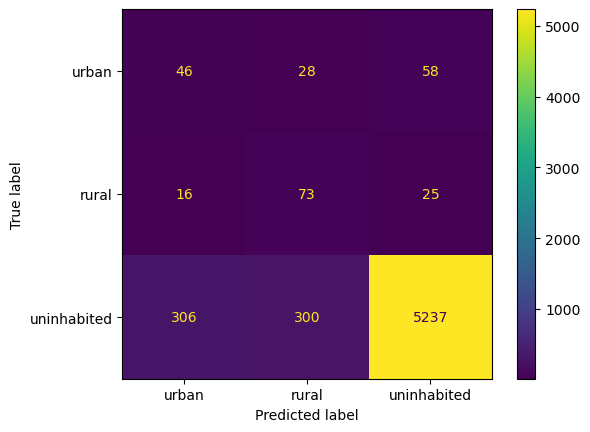

In [10]:
classes = ["urban", "rural", "uninhabited"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

...and visualize the model's top predictions on some satellite tiles:

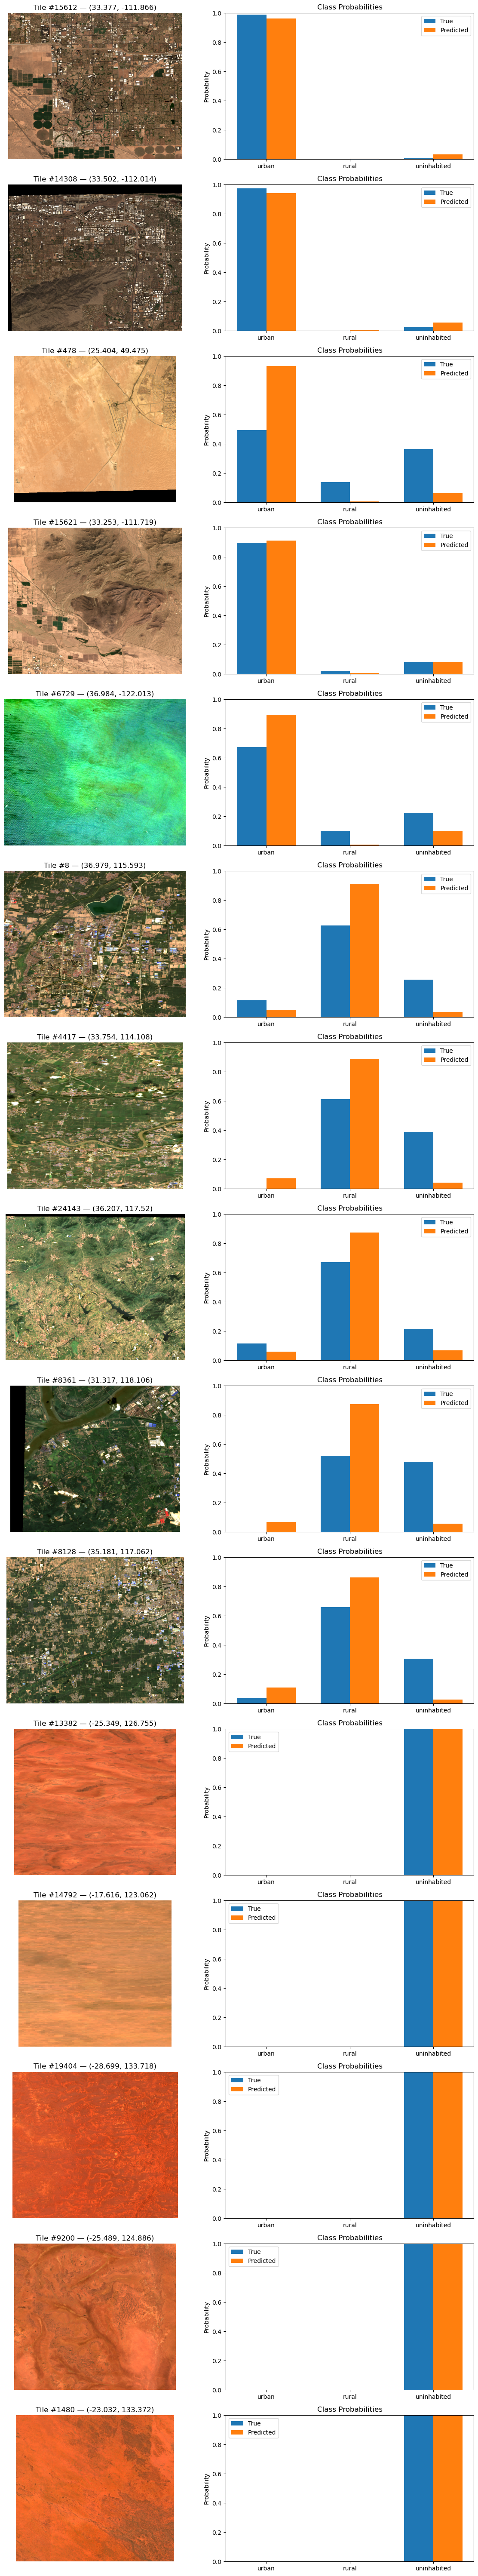

In [11]:
selected_rows = []
top_n = 5

for cls in range(3):
    tp = np.where((y_test == cls) & (y_pred == cls))[0]
    if len(tp) == 0:
        continue
        
    tp_conf = y_pred_probs[tp, cls]
    top_tp = tp[np.argsort(tp_conf)[::-1]]
    
    selected_rows_cls = top_tp[:top_n]  # take top_n only for this class
    selected_rows.extend(selected_rows_cls)

fig, axes = plt.subplots(len(selected_rows), 2, figsize=(12, 4 * len(selected_rows)))
x = np.arange(3)

for row, i in enumerate(selected_rows):
    with rasterio.open(f"HLS2-s30_rgb/tile{idx_test[i]}.tif") as src:
        img = src.read([1,2,3]).astype(np.float32)
        img /= np.percentile(img, 99)
        img = np.clip(img, 0, 1)
        
        height, width = img.shape[1], img.shape[2]
        center_x, center_y = src.transform * (height // 2, height // 2)
        center_x, center_y = round(center_x, 3), round(center_y, 3)
        
        axes[row, 0].imshow(img.transpose(1,2,0))
        axes[row, 0].set_title(f"Tile #{idx_test[i]} — ({center_y}, {center_x})")
        axes[row, 0].axis("off")

        axes[row, 1].bar(x - .35/2, y[idx_test[i]], .35, label="True")
        axes[row, 1].bar(x + .35/2, y_pred_probs[i], .35, label="Predicted")
        axes[row, 1].set_xticks(x)
        axes[row, 1].set_xticklabels(classes)
        axes[row, 1].set_ylim(0, 1)
        axes[row, 1].set_ylabel("Probability")
        axes[row, 1].legend()
        axes[row, 1].set_title("Class Probabilities")

plt.tight_layout()
plt.show()